## RL test task: MountainCar-v0

**DQN algorithm implementation**

In [1]:
import torch
from torch import nn, optim
import copy
import random
import gym

device = torch.device('cuda')

In [2]:
# agent's replay memory
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def append(self, elem):
        if len(self.memory) < self.capacity:
            self.memory.append(elem)
        self.memory[self.position] = elem
        self.position = (self.position + 1) % self.capacity
            
    def get_minibatch(self, size):
        return random.sample(self.memory, size)
    
    
    def __len__(self):
        return len(self.memory)

In [3]:
# epsilon-greedy strategy
def select_action(epsilon, state, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
    return model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()

In [4]:
def optimize(batch):
    state, action, reward, next_state, is_terminal = batch
    
    state = torch.tensor(state).to(device).float()
    action = torch.tensor(action).to(device)
    reward = torch.tensor(reward).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    
    target_q = torch.zeros(reward.size()[0]).float().to(device)
    with torch.no_grad():
        target_q[is_terminal] = target_model(next_state).max(1)[0].detach()[is_terminal]
    target_q = reward + target_q * GAMMA
        
    q = model(state).gather(1, action.unsqueeze(1))
    
    loss = nn.functional.smooth_l1_loss(q, target_q.unsqueeze(1))
    
    optimizer.zero_grad()
    
    loss.backward()
    
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()

In [5]:
def exploit(model, render = True):
    state = env.reset()
    r = 0.
    is_terminal = False
    
    while not is_terminal:
        eps = 0.
        if render:
            env.render()
        action = select_action(eps, state, model)
        state, reward, is_terminal, _ = env.step(action)
        r += reward
    return r

In [6]:
def train(model, target_model, optimizer):
    reward_history = []
    replay_memory = Memory(MEMORY_CAPACITY)
    
    state = env.reset()
        
    for step in range(1, MAX_STEP):
        # select action
        eps = MAX_EPS - (MAX_EPS - MIN_EPS) * step / MAX_STEP 
        action = select_action(eps, state, model)

        # execute action in emulator
        new_state, reward, is_terminal, _= env.step(action)

        
        # store info in replay memory
        replay_memory.append((state, action, reward + 200 * (GAMMA * abs(new_state[1]) - abs(state[1])),
                              new_state, is_terminal))

        # update state
        if is_terminal:
            state = env.reset()
            is_terminal = False
        else:
            state = new_state
        
        # make gradient descent step
        # sample random minibatch from replay memory
        if step > BATCH_SIZE:
            optimize(list(zip(*replay_memory.get_minibatch(BATCH_SIZE))))
            
        # update target model 
        if step % UPDATE_STEP == 0:
            target_model = copy.deepcopy(model)
            r = exploit(target_model, True)
            reward_history.append(r)
            
    return reward_history

In [7]:
# define constants
BATCH_SIZE = 128

MAX_STEP = 70001
UPDATE_STEP = 1000

MAX_EPS = 0.5
MIN_EPS = 0.1

MEMORY_CAPACITY = 5000

GAMMA = 0.99

In [8]:
# create environment
env = gym.make('MountainCar-v0')

# create model + optimizer
model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 3))

target_model = copy.deepcopy(model)

def init_model_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
        
model.apply(init_model_weights)

model.to(device)
target_model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-5)

In [9]:
rewards = train(model, target_model, optimizer)

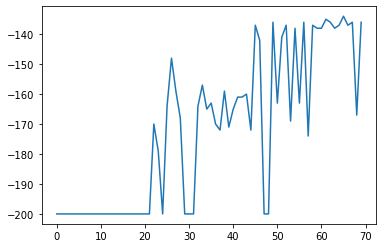

In [11]:
import matplotlib.pyplot as plt

plt.plot(rewards)